In [1]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 150

# disabling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
# pd.set_option('display.max_rows', None, 'display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import math
import scipy.stats as stats

# sklearn data science library
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression


from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# .py files
import acquire
import prepare
import model

In [2]:
df = acquire.get_bach_df()

dataframe shape: (71901, 139)


In [3]:
df = prepare.clean_college_df(df)
df = prepare.clean_high_percentage_nulls(df)
df = prepare.obtain_target_variables(df)

dataframe shape: (71901, 117)
dataframe shape: (71422, 127)


In [4]:
# Creating income brackets

income_0_30000 = [
'other_fam_income_0_30000',
 'private_fam_income_0_30000',
 'program_fam_income_0_30000',
 'pub_fam_income_0_30000']

income_30001_48000 = [
 'other_fam_income_30001_48000',
 'private_fam_income_30001_48000',
 'program_fam_income_30001_48000',
 'pub_fam_income_30001_48000']

income_48001_75000 = [
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000']

income_75001_110000 = [
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000']

income_over_110000 = [
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000']


In [5]:

# Additional transformation including feature engineering and imputing missing values
df = prepare.create_fam_income_columns(df)
df = prepare.impute_avg_net_price(df)
df = prepare.impute_debt(df)


dataframe shape: (71422, 112)


In [6]:
# Creating region category feature from `state_post_code`
df['us_region'] = df.apply(lambda row: prepare.label_states(row), axis=1)

In [7]:
train, validate, test = prepare.split_data(df)

train shape: (39995, 113)
validate shape: (17142, 113)
test shape: (14285, 113)


In [8]:
# Capping outliers on train df
train = prepare.percentile_capping(train, 0.1, 0.1)
validate = prepare.percentile_capping(validate, 0.1, 0.1)
test = prepare.percentile_capping(test, 0.1, 0.1)

In [9]:
train_imputed = prepare.train_iterative_imputer(train)

In [10]:
validate_imputed, test_imputed = prepare.impute_val_and_test(train, validate, test)

In [11]:
print('Imputed Train shape: {}.'.format(train_imputed.shape))
print('Imputed Validate shape: {}.'.format(validate_imputed.shape))
print('Imputed Test shape: {}.'.format(test_imputed.shape))

Imputed Train shape: (39995, 113).
Imputed Validate shape: (17142, 113).
Imputed Test shape: (14285, 113).


In [12]:
train.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000,us_region
25530,220862.0,University of Memphis,Public,TN,38152,Memphis,5.0,1.0,3.0,3.0,...,1.9370,193.7021,5.5278,552.7786,559.0,300.0,248.0,186.0,209.0,east_south_central
53875,218238.0,Limestone University,"Private, nonprofit",SC,29340-3799,Gaffney,5.0,1.0,3.0,3.0,...,1.7703,177.0293,5.1729,517.2892,106.0,51.0,57.0,39.0,49.0,east_south_atlantic
42932,228459.0,Texas State University,Public,TX,78666,San Marcos,6.0,1.0,3.0,3.0,...,1.5812,158.1241,4.7455,474.5477,559.0,300.0,303.0,274.0,471.0,midwest_south_central
45495,146339.0,Judson University,"Private, nonprofit",IL,60123-1498,Elgin,3.0,1.0,3.0,3.0,...,2.5036,250.3619,6.7900,678.9995,28.0,16.0,37.0,29.0,28.0,east_north_central
25003,197708.0,Yeshiva University,"Private, nonprofit",NY,10033-3299,New York,2.0,1.0,3.0,3.0,...,1.0279,102.7869,3.5071,350.7116,58.0,26.0,34.0,34.0,97.0,east_north_atlantic


In [13]:
train.median_debt_completed.value_counts()

27000    4185
23250    3141
25000    2763
26000    1688
21500    1085
         ... 
20872       1
10669       1
26366       1
26730       1
18544       1
Name: median_debt_completed, Length: 904, dtype: int64

<AxesSubplot:xlabel='median_debt_completed', ylabel='major_category'>

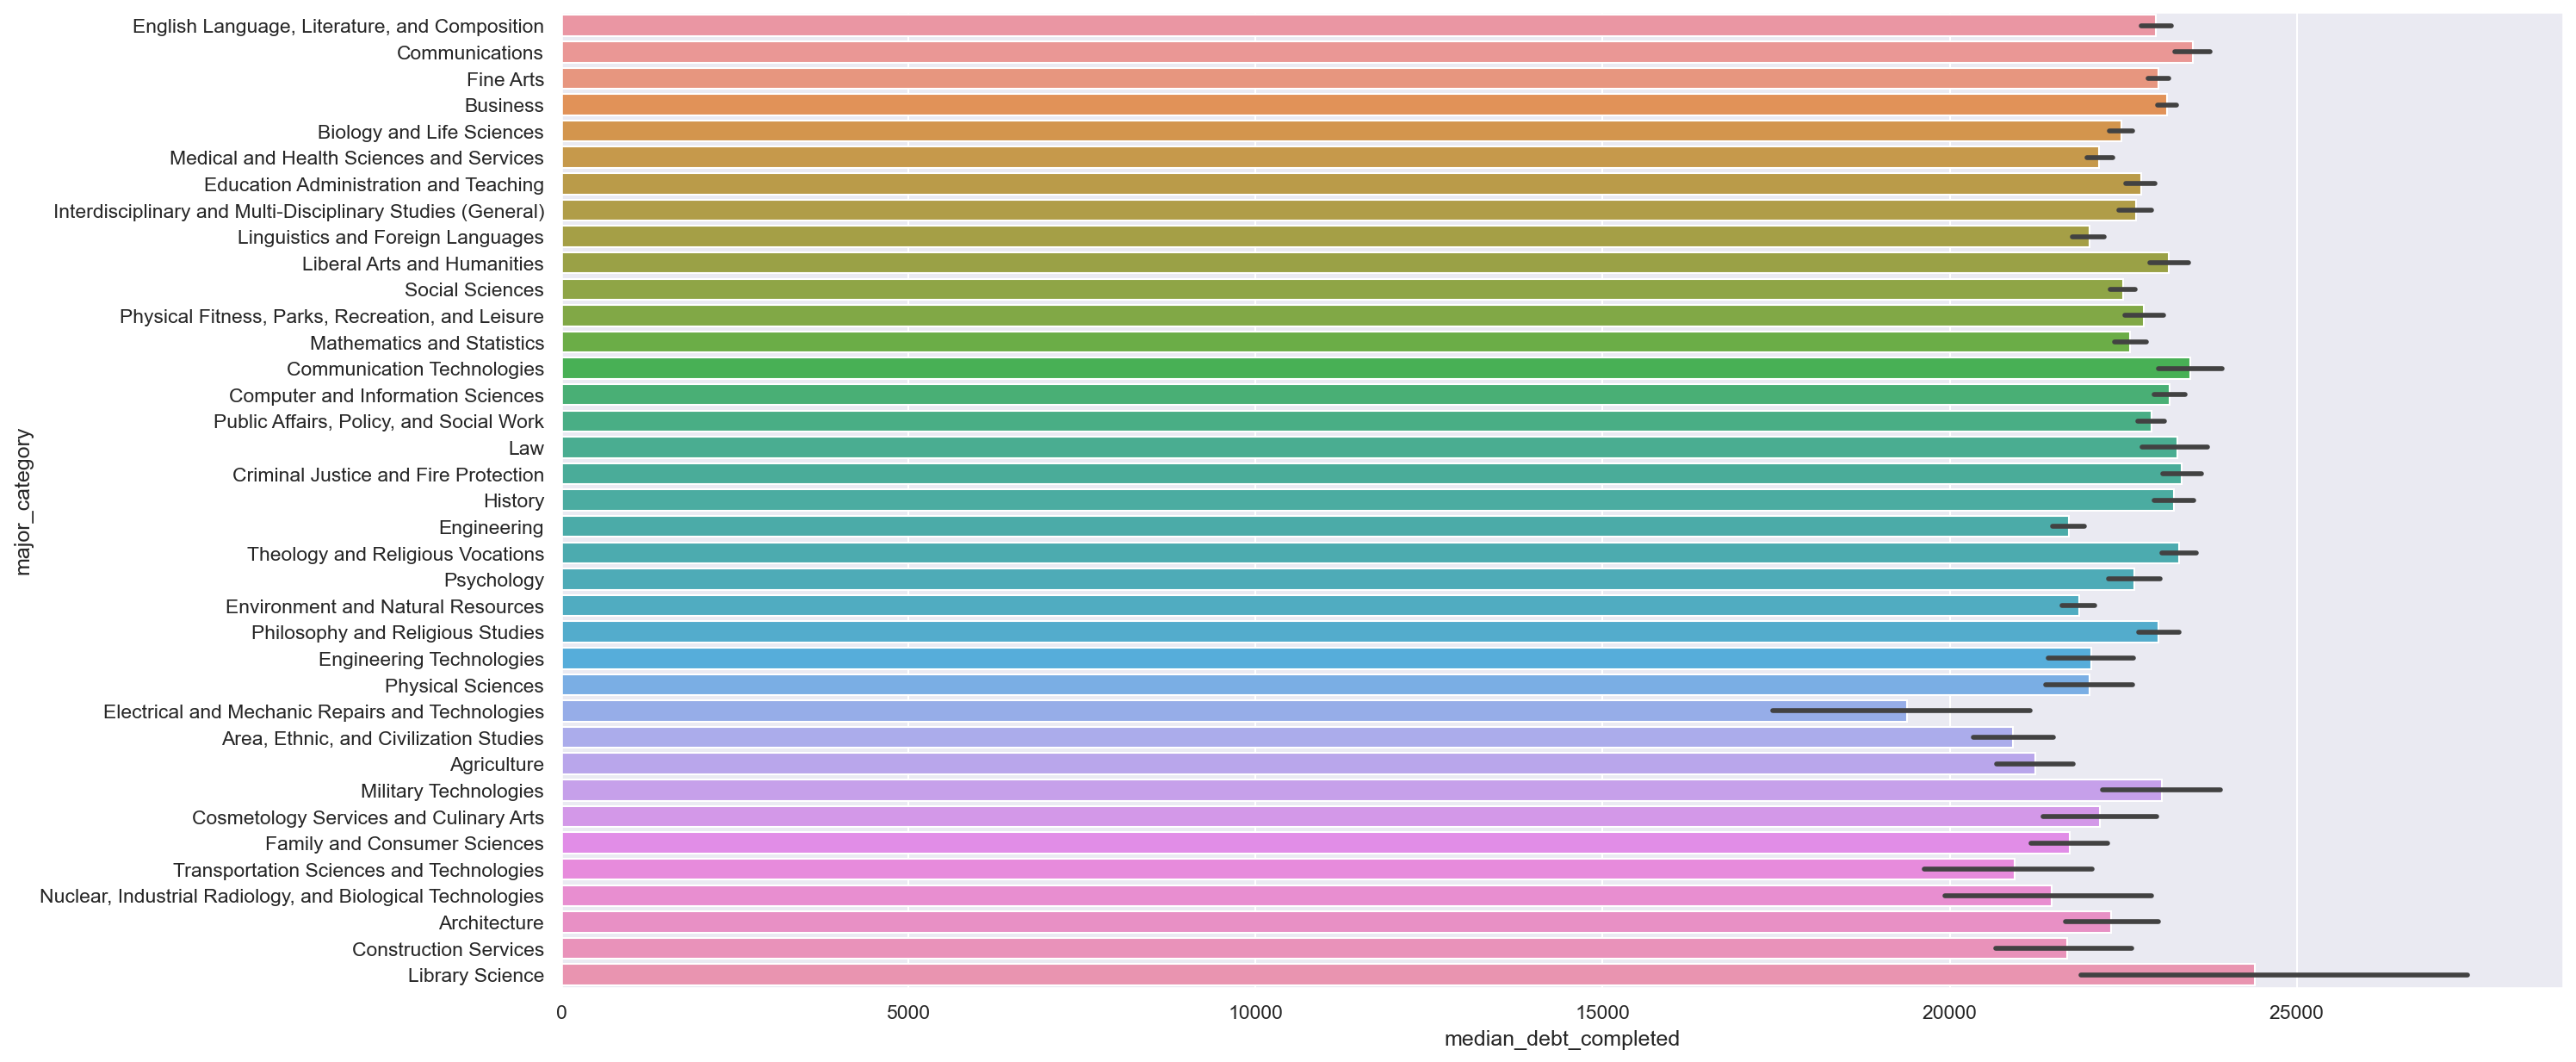

In [15]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_completed', data=train)

<AxesSubplot:xlabel='median_debt_completed', ylabel='institution_control'>

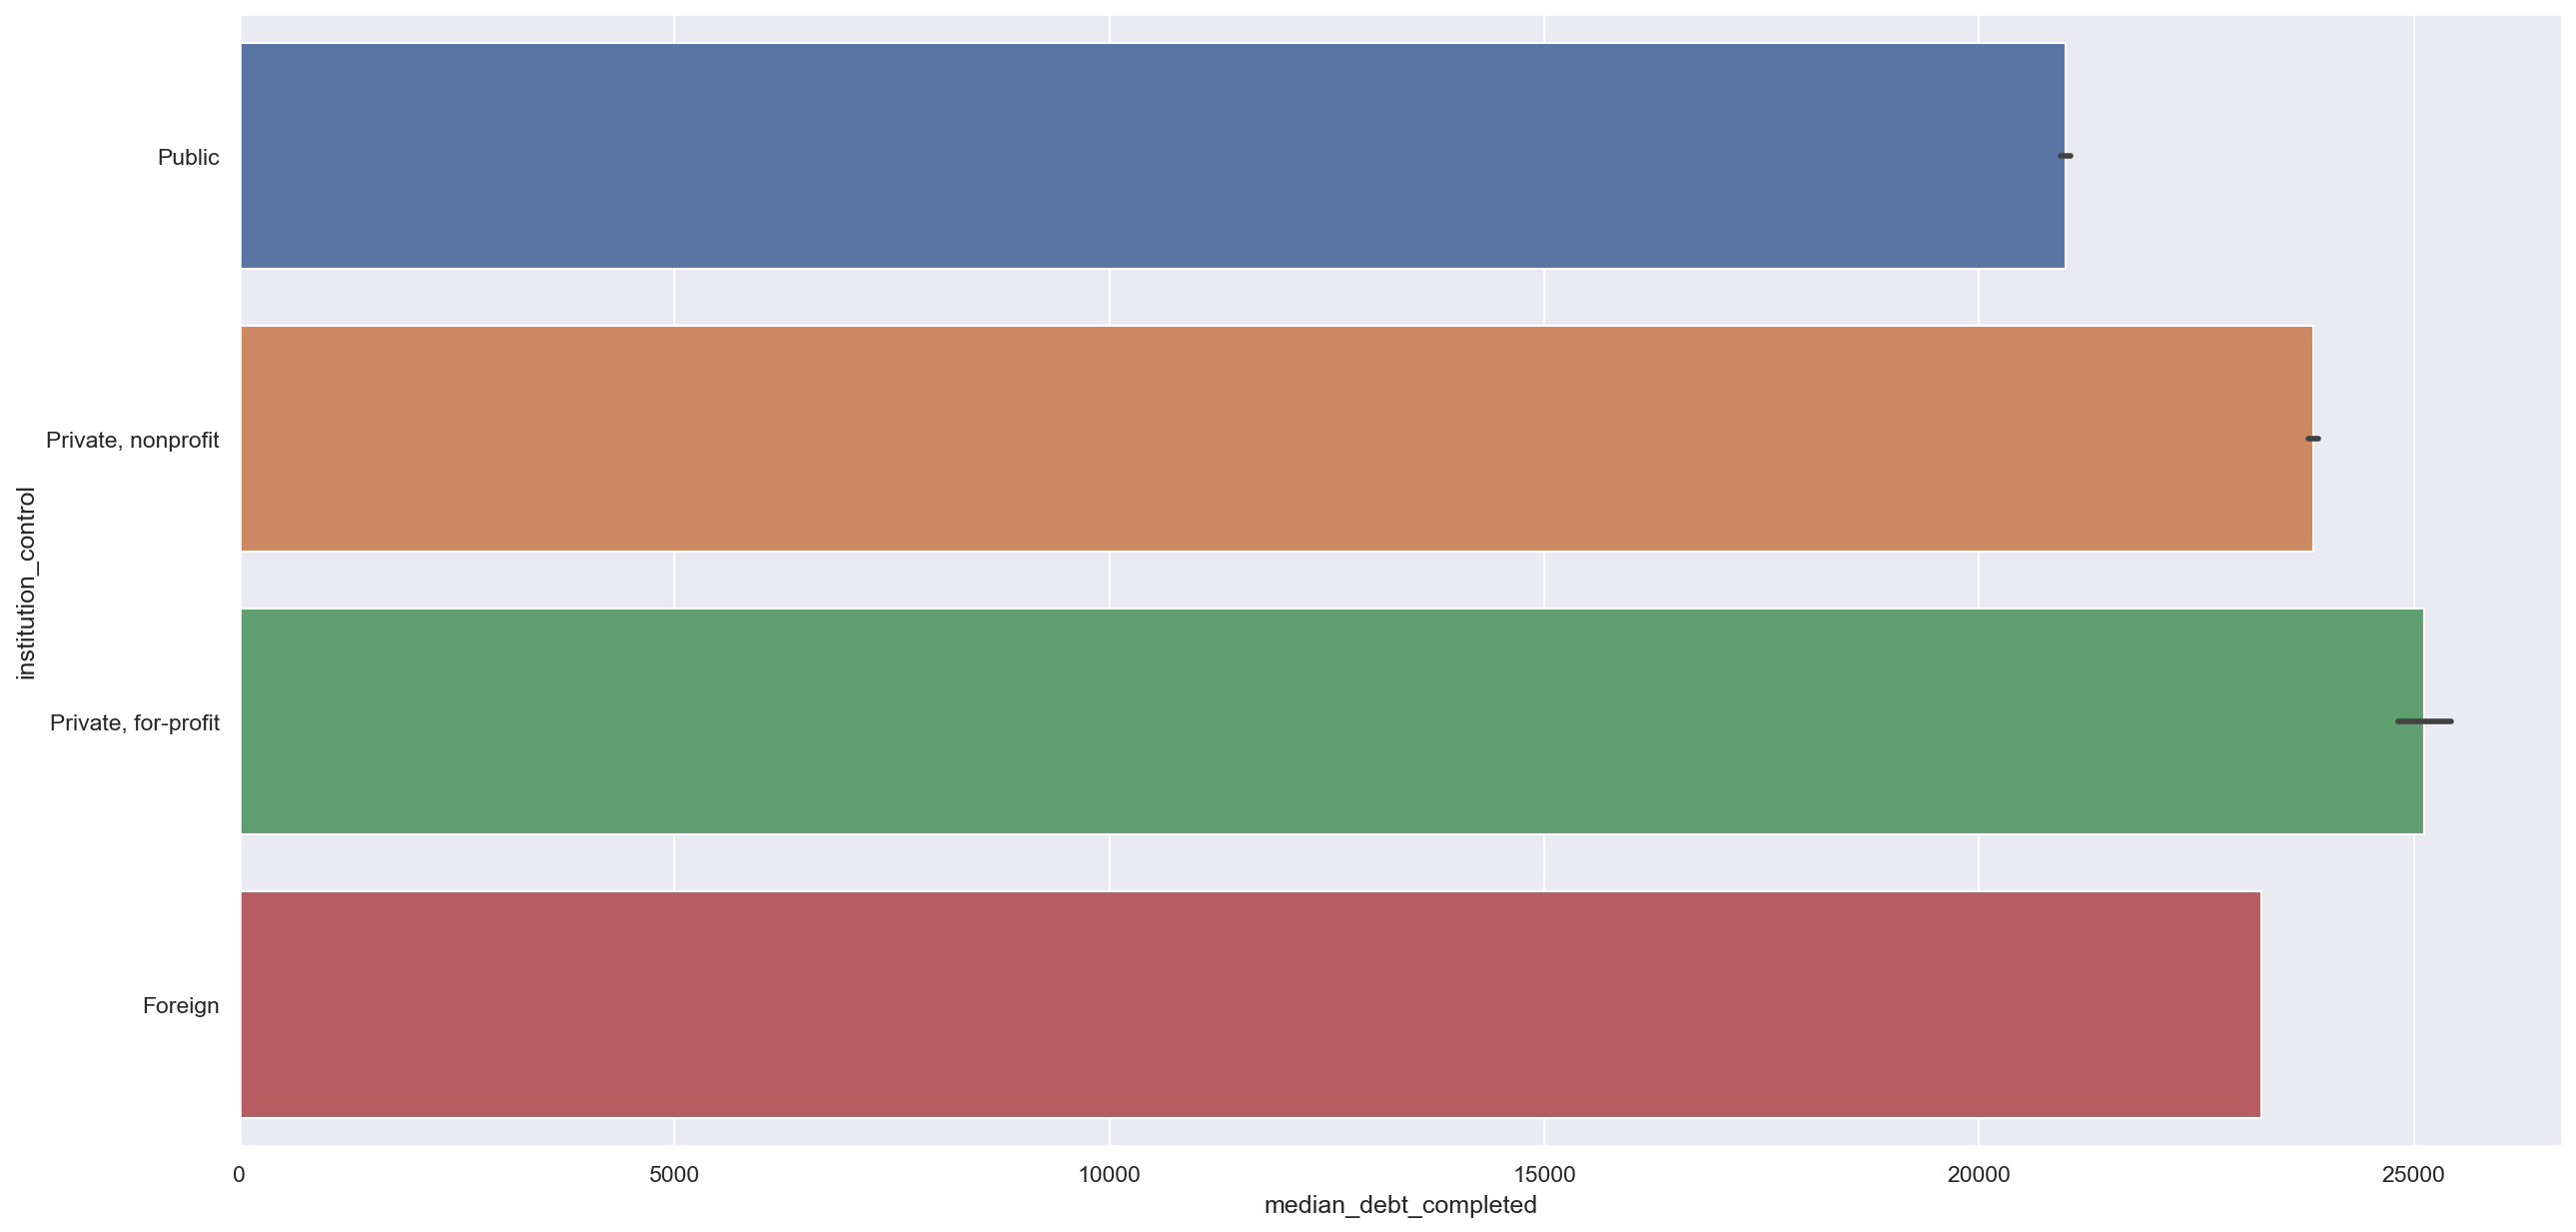

In [16]:
plt.figure(figsize=(20,10))
sns.barplot(y='institution_control', x='median_debt_completed', data=train)

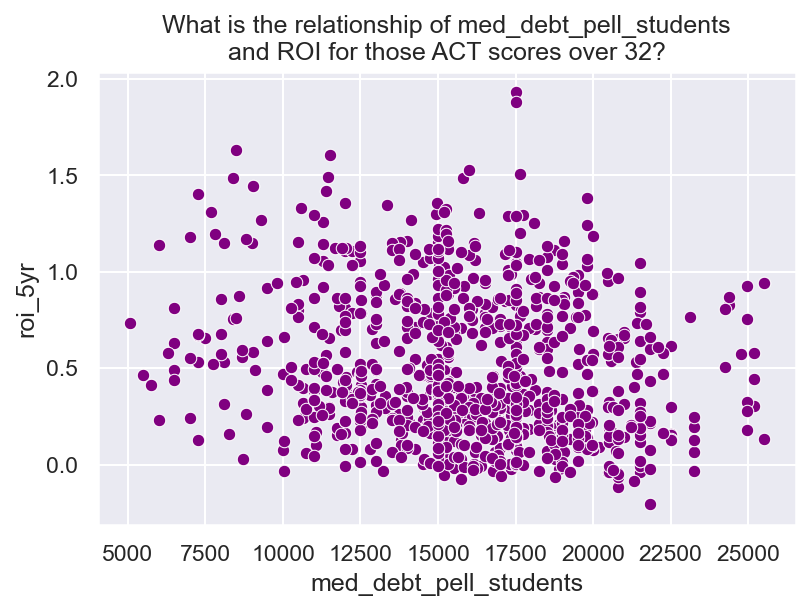

In [18]:
sns.scatterplot(x='med_debt_pell_students', y='roi_5yr', 
                data=train[train.institution_control == "Public"].sample(1000), 
                color='purple'
               )

plt.title("What is the relationship of med_debt_pell_students\nand ROI for those ACT scores over 32?")
plt.show()

<AxesSubplot:xlabel='median_debt_completed', ylabel='major_category'>

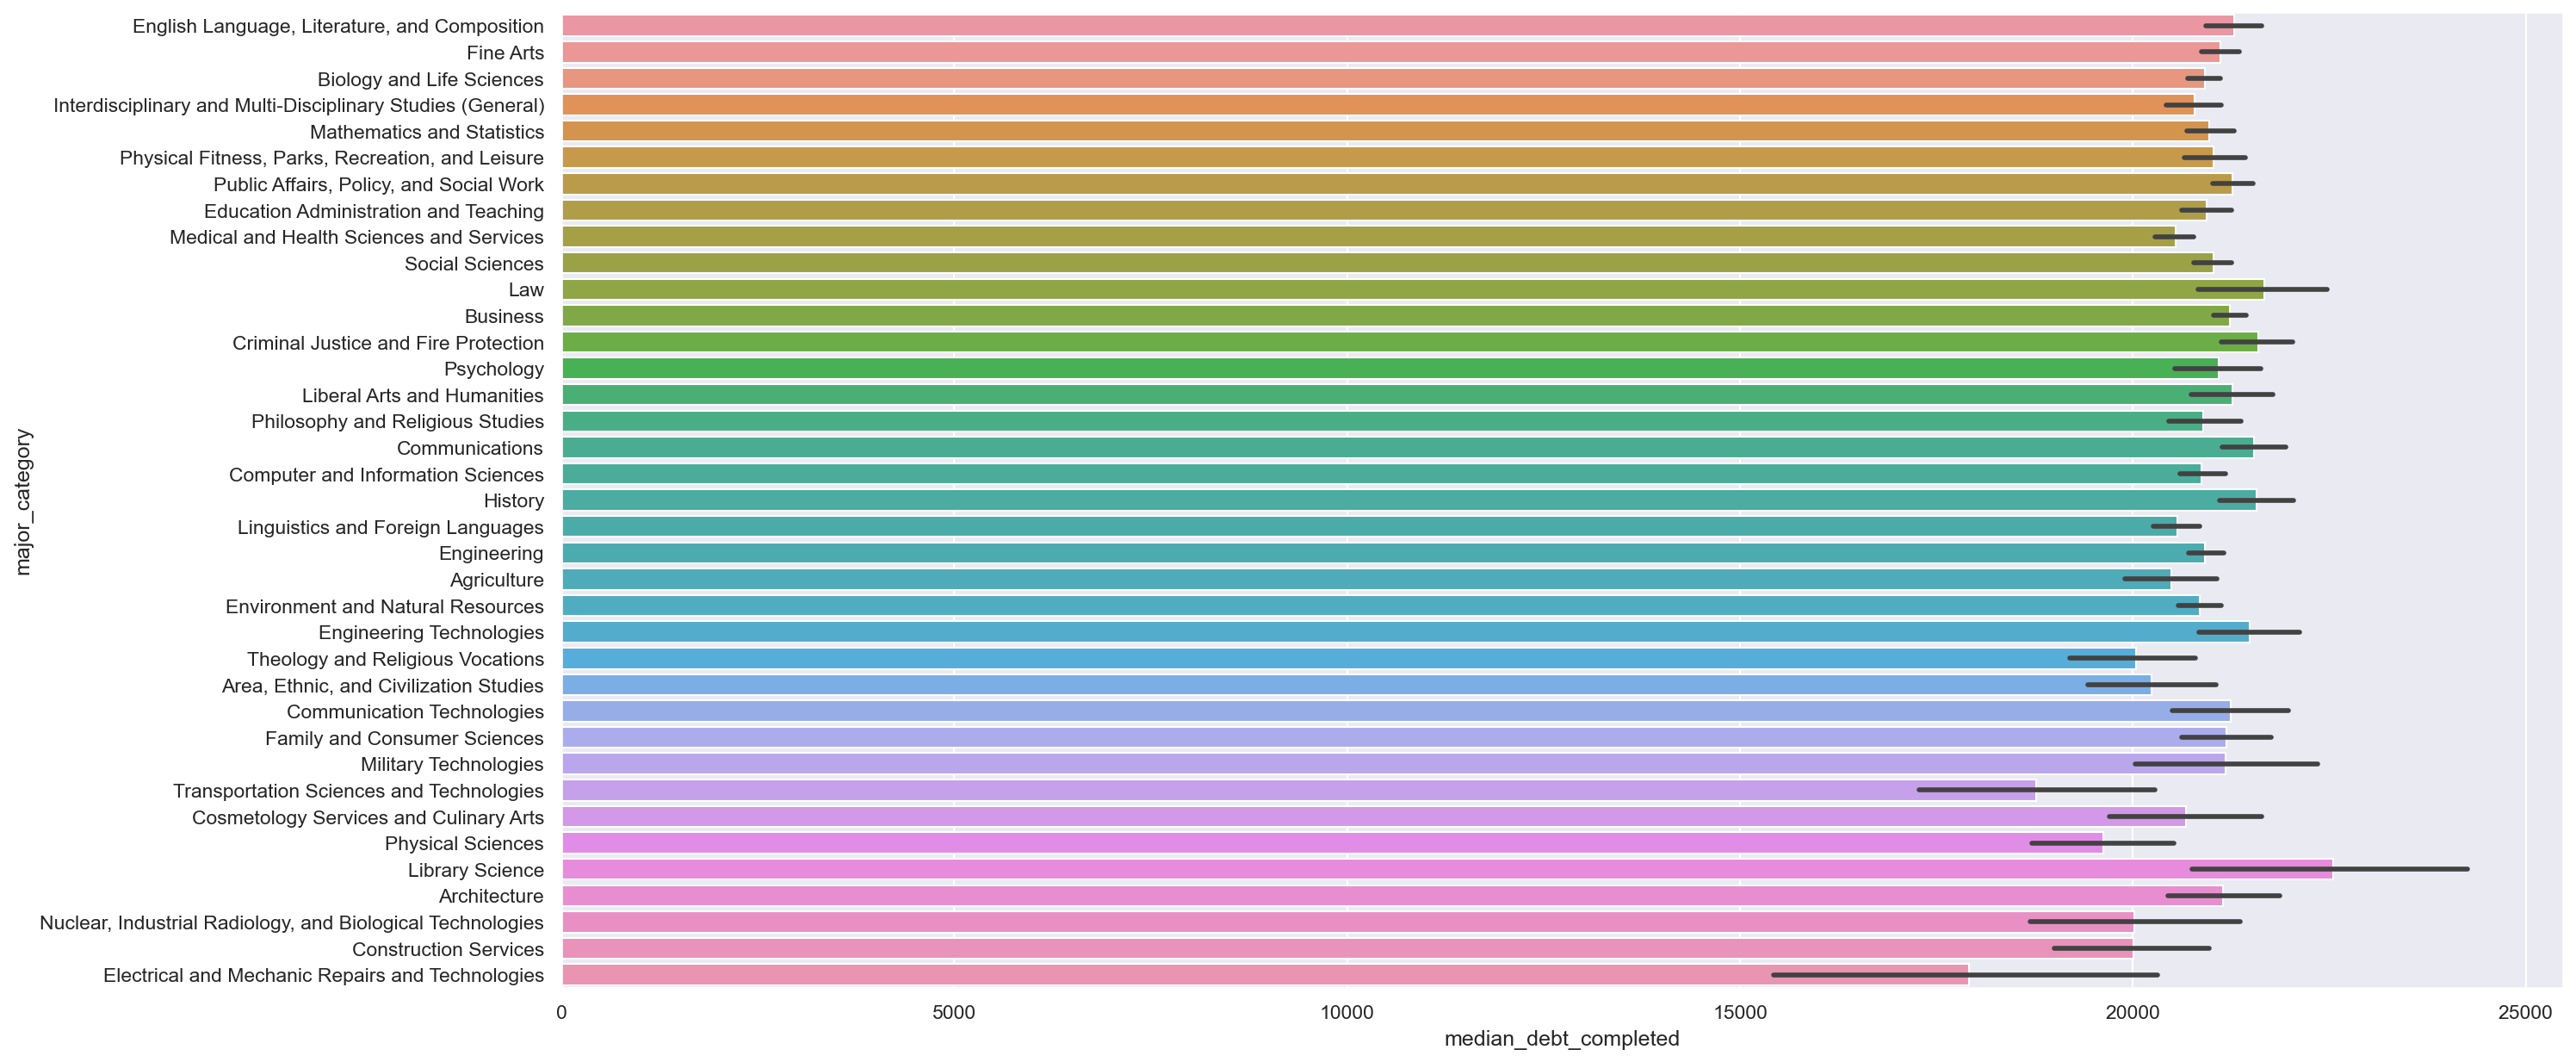

In [20]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_completed', data=train[train.institution_control == "Public"])

In [21]:
train.institution_control.value_counts()

Private, nonprofit     20834
Public                 16389
Private, for-profit     1786
Foreign                  986
Name: institution_control, dtype: int64

<AxesSubplot:xlabel='median_debt_completed', ylabel='major_category'>

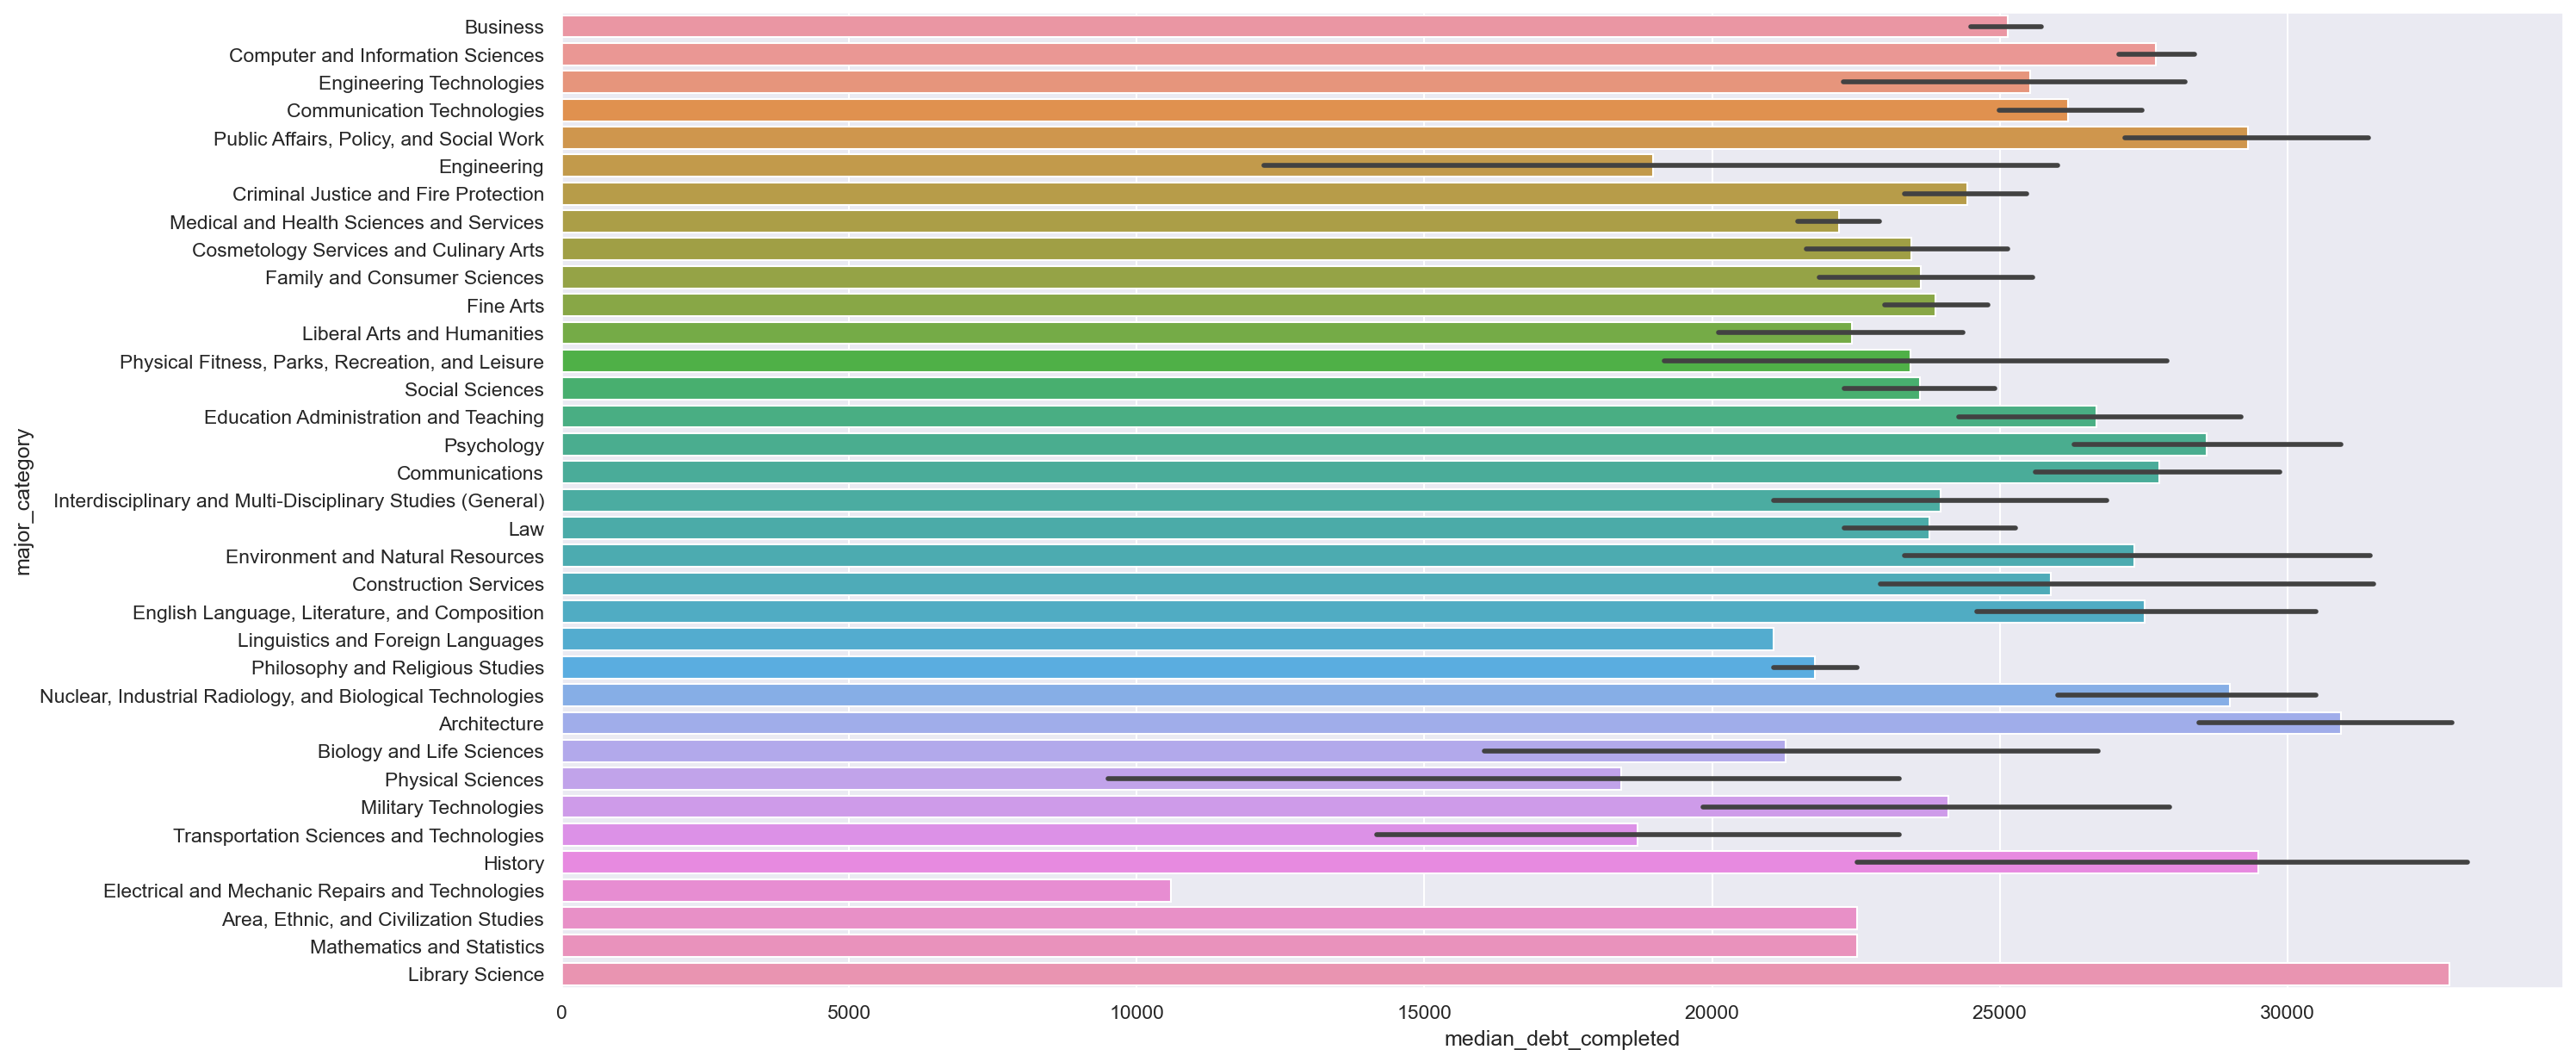

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_completed', data=train[train.institution_control == "Private, for-profit"])

<AxesSubplot:xlabel='median_debt_completed', ylabel='major_category'>

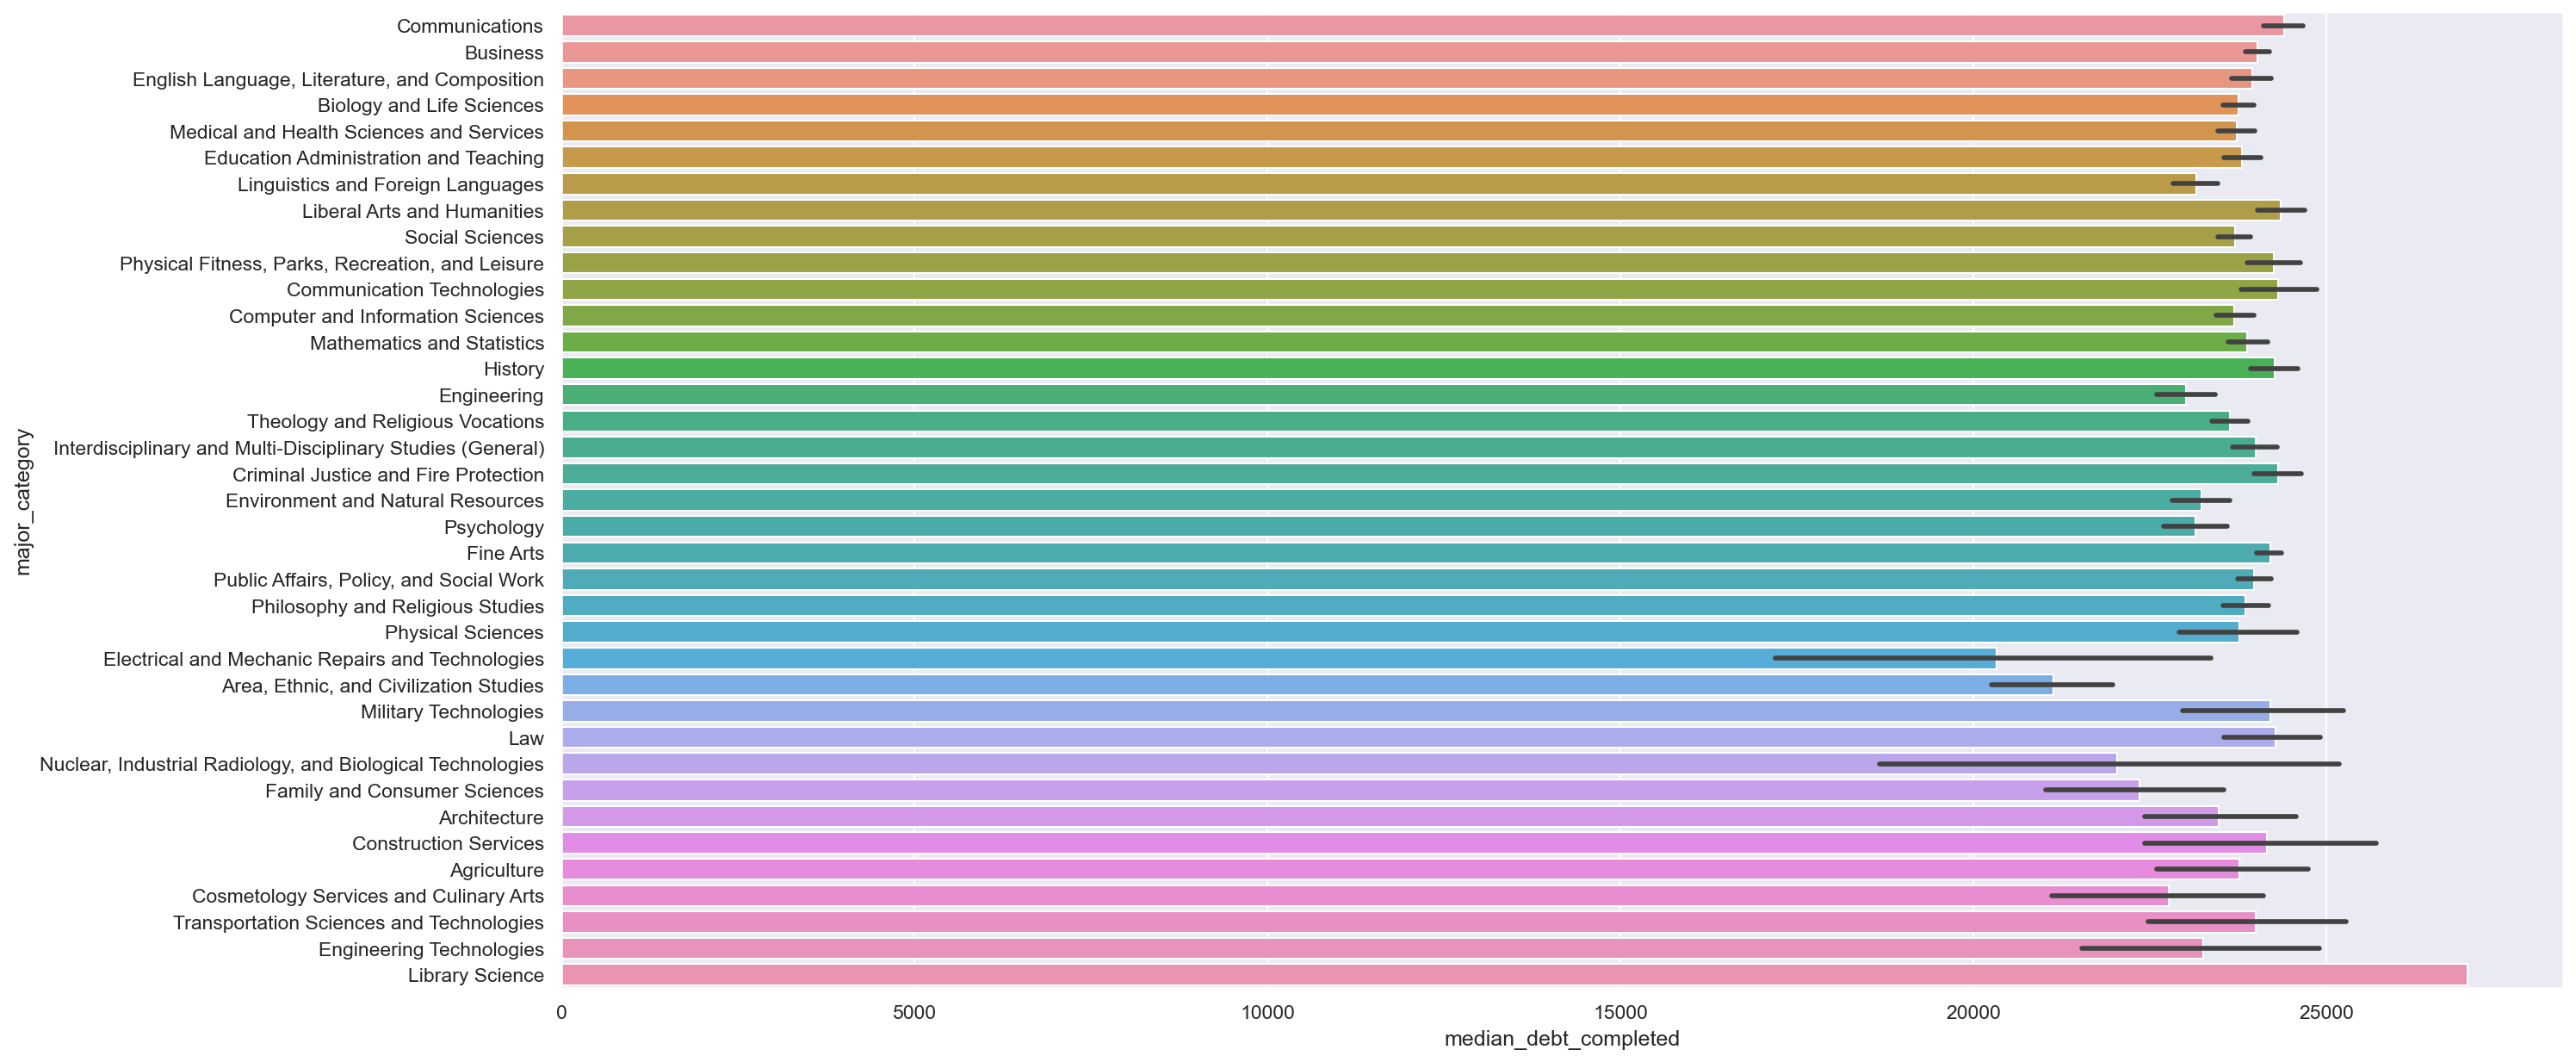

In [23]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_completed', data=train[train.institution_control == "Private, nonprofit"])

<AxesSubplot:xlabel='median_debt_completed', ylabel='major_category'>

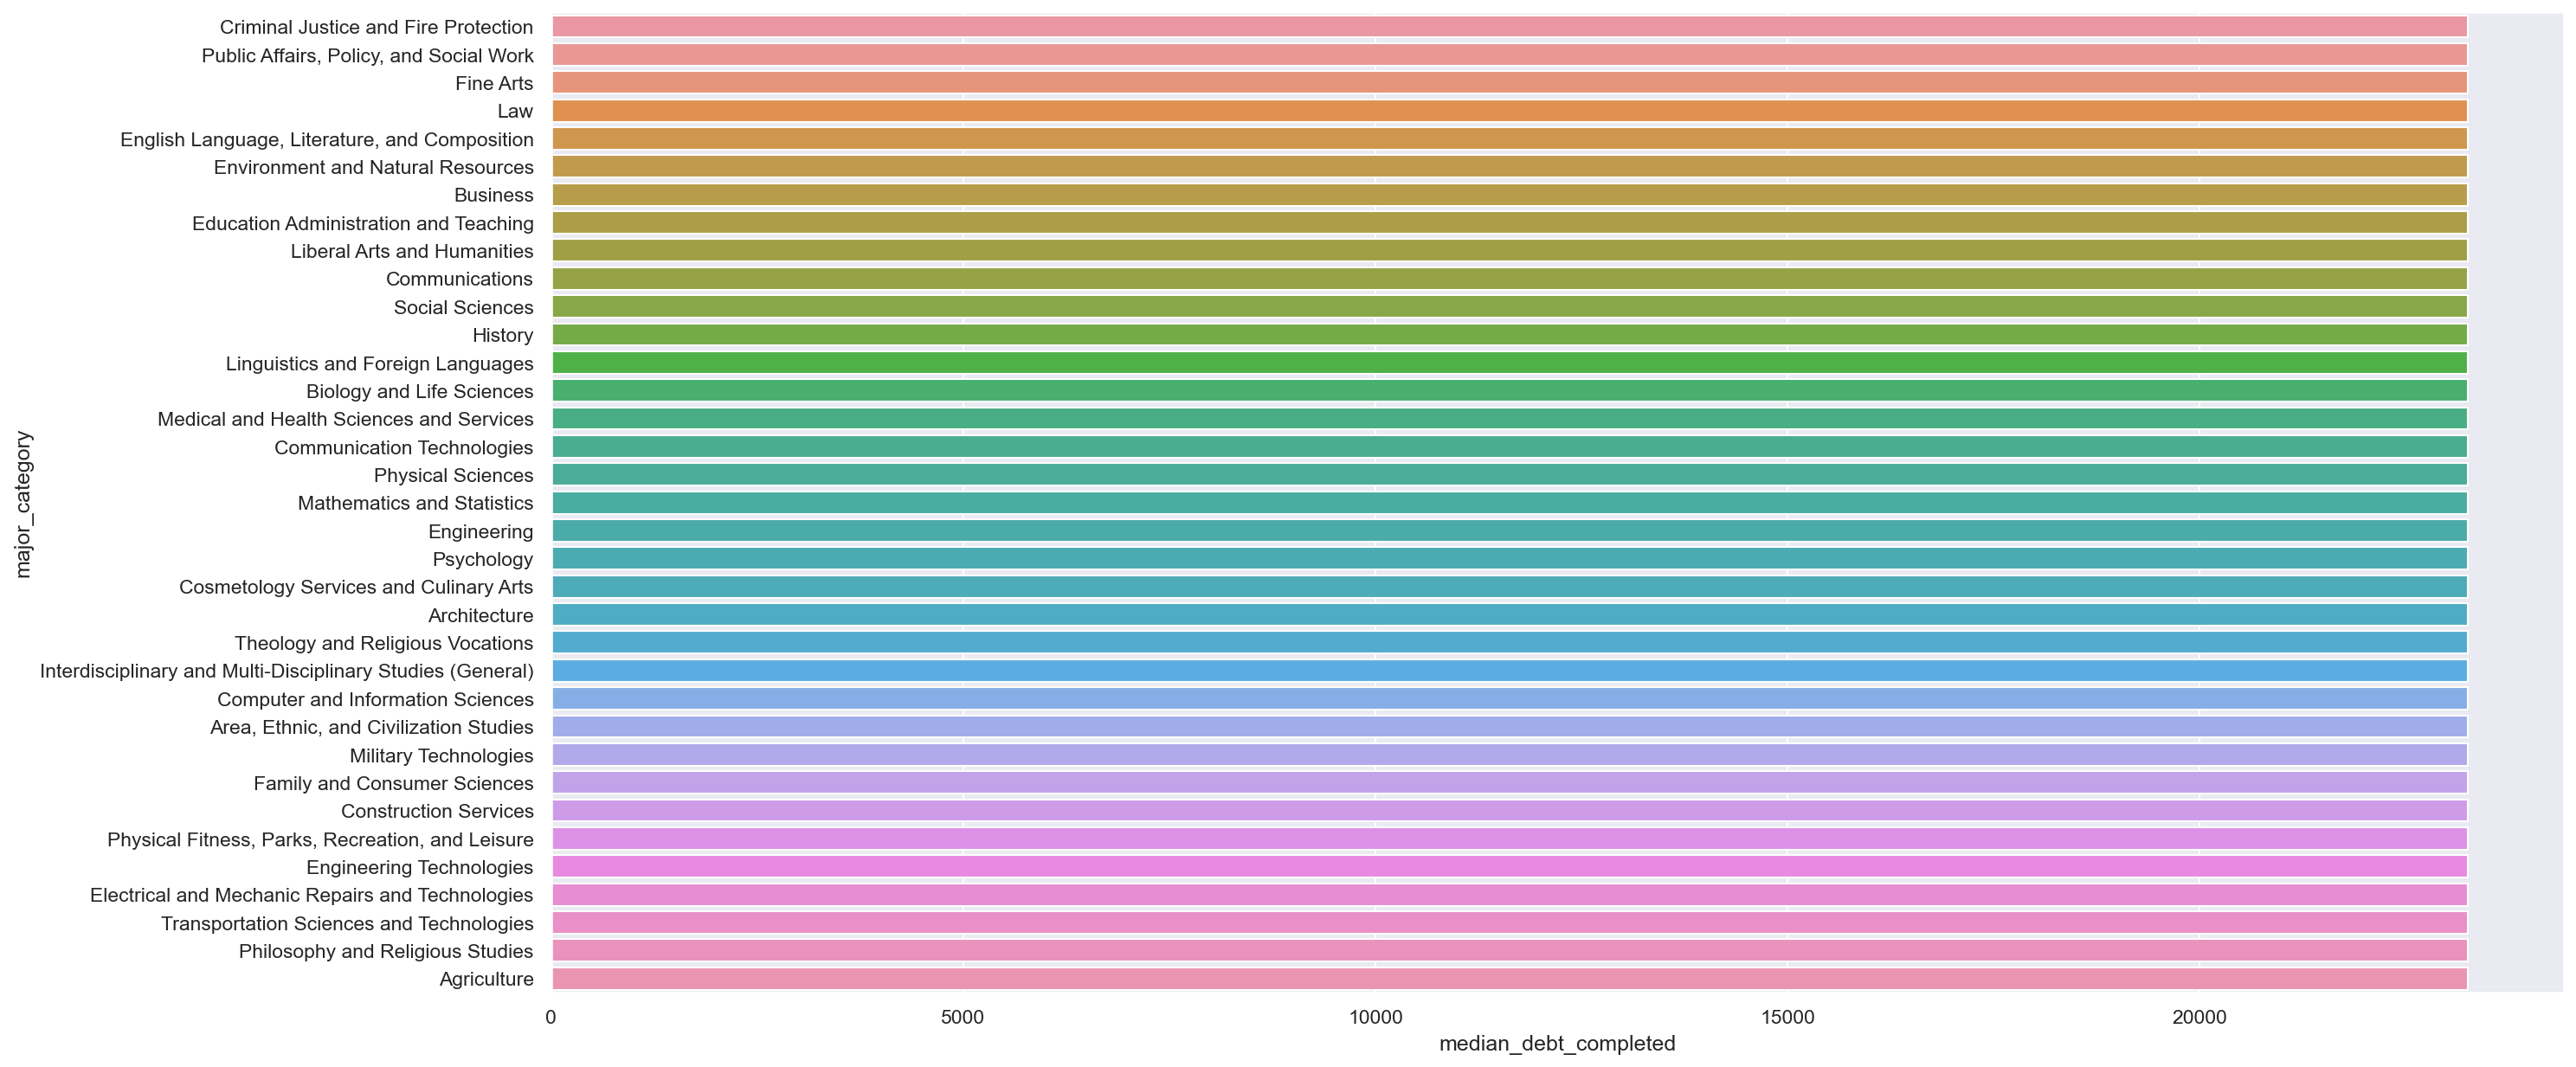

In [24]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_completed', data=train[train.institution_control == "Foreign"])

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(y='major_category', x='median_debt_pell', data=train[train.institution_control == "Private, for-profit"])

In [25]:
train.median_debt_completed.describe()

count    39995.000000
mean     22717.313914
std       4522.127404
min       3500.000000
25%      20500.000000
50%      23250.000000
75%      25988.000000
max      45881.000000
Name: median_debt_completed, dtype: float64